Simple Naive Bayes classifier

In [49]:
from __future__ import division


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Setting background for plots
sns.set(style='darkgrid')


import numpy as np
import random
import re
import sklearn.datasets as skds
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

#%matplotlib inline
#from __future__ import division

#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
#import scipy.stats as stats
#import seaborn as sns

#from matplotlib import cm

# Setting background to plots
#sns.set(style="darkgrid")

----

In [162]:
lang_map = {
    'en':'English',
    'fr':'French',
    'de':'German',
    'es':'Spanish',
    'it':'Italian',
    'pt':'Portuguese'
}
corpi = {
    'all':'../data/corpus',
    'en':'../data/en_corpus',
    'de':'../data/de_corpus',
    'es':'../data/es_corpus',
    'fr':'../data/fr_corpus'
}
languages = ['en','de','es','fr']

# Lexical tests
lex_corpi = {
    'all' : '../data/lexical/corpus',
    'es' : '../data/lexical/es_corpus',
    'fr' : '../data/lexical/fr_corpus',
    'it' : '../data/lexical/it_corpus',
    'pt' : '../data/lexical/pt_corpus',
}
lex_languages = ['es','fr','it','pt']

**load_corpus**

Loads the entire experimental corpus and returns it as a bunch.
- _source_ source directory of the corpus
- _encoding_ encoding of the corpus.  Default is UTF-8.
- _languages_ languages to load from the corpus.  Default will load all.

In [10]:
def load_corpus(source="../data/corpus", encoding='UTF-8', languages=None):
    return skds.load_files(source, encoding=encoding, categories=languages, shuffle=True)

In [11]:
def test_load_corpus():
    corpus = load_corpus(languages=['en'])
    assert corpus.target_names[0] == 'en'
    
    corpus = load_corpus(languages=['de','es','fr'])
    print corpus.target_names
    assert len(corpus.target_names) == 3
    
    corpus = load_corpus()
    print corpus.target_names
    assert len(corpus.target_names) == 4
    
    
test_load_corpus()

['de', 'es', 'fr']
['de', 'en', 'es', 'fr']


**token_pattern**

Returns a token pattern for unicode alphabetical character words only.  No numbers or underscores allowed.8

In [173]:
def token_pattern():
    return '(?u)\\b[^\W_0-9]{2,}\\b'

In [174]:
def single_char_token_pattern():
    return '(?u)\\b[^\W_0-9]{1,}\\b'

**font_sizes**

In [100]:
title_fontsize = 20
x_axis_fontsize = 18
y_axis_fontsize = 18
legend_fontsize = 14

----
**Background:  Data **

A total of 4,000 paragraphs were extracted from the Wikipedia articles at _X_ - 1,000 messages for each of four languages: English, German, Spanish and French. Paragraphs were identified by `<p>` tag blocks.  Each paragraph had any embedded HTML tags used for formatting purposes removed. Embedded anchor tags were removed and replaced with the word or phrase appearing between the `<a></a>` tags as this was often a legimate word or phrase in the source language and the anchor was simply there to facilitate connectivity between articles on related concepts.

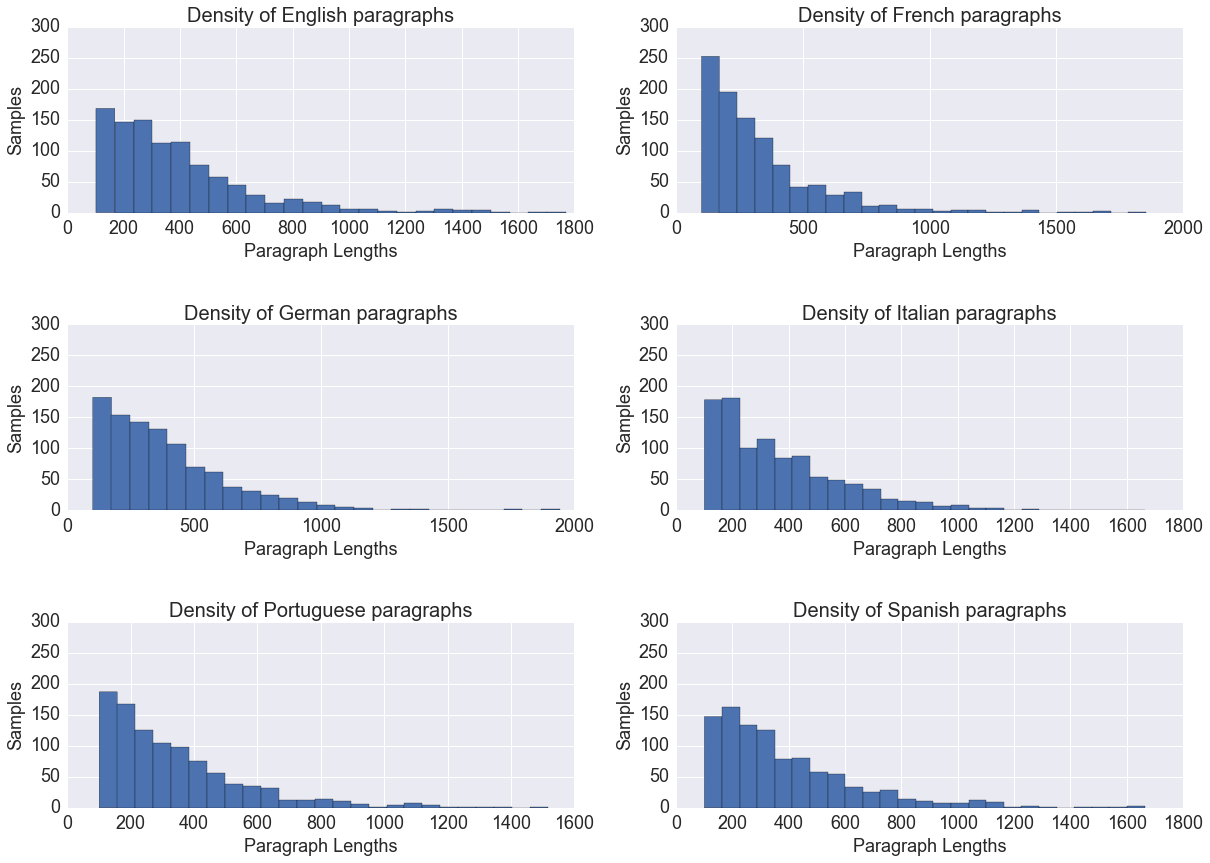

In [30]:
# Plot a histogram of the English message data
en_lengths = [len(p) for p in load_corpus(languages=['en']).data]
fr_lengths = [len(p) for p in load_corpus(languages=['fr']).data]
de_lengths = [len(p) for p in load_corpus(languages=['de']).data]
it_lengths = [len(p) for p in skds.load_files(lex_corpi['it'], encoding='UTF-8', shuffle=True, categories=['it']).data]              
pt_lengths = [len(p) for p in skds.load_files(lex_corpi['pt'], encoding='UTF-8', shuffle=True, categories=['pt']).data]  
es_lengths = [len(p) for p in load_corpus(languages=['es']).data]


title_fontsize = 20
x_axis_fontsize = 18
y_axis_fontsize = 18

bins = 25
y = [0, 300]
figure = plt.figure(figsize=(20,14))

def configure_axes(language, lengths, bins, y_lim, axes):
    axes.hist(lengths, bins)
    axes.set_title("Density of {0} paragraphs".format(language))
    axes.title.set_fontsize(title_fontsize)
    
    # Y axes
    axes.set_ylabel("Samples")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_ylim(y_lim)
    
    # X axes
    axes.set_xlabel("Paragraph Lengths")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    return axes

# English      
en_axes = figure.add_subplot(3,2,1)
en_axes = configure_axes("English", en_lengths, bins, y, en_axes)
        
# French
fr_axes = figure.add_subplot(3,2,2)
fr_axes = configure_axes("French", fr_lengths, bins, y, fr_axes)

# German
de_axes = figure.add_subplot(3,2,3)
de_axes = configure_axes("German", de_lengths, bins, y, de_axes)

# Italian
it_axes = figure.add_subplot(3,2,4)
it_axes = configure_axes("Italian", it_lengths, bins, y, it_axes)

# Portuguese
pt_axes = figure.add_subplot(3,2,5)
pt_axes = configure_axes("Portuguese", pt_lengths, bins, y, pt_axes)

# Spanish
es_axes = figure.add_subplot(3,2,6)
es_axes = configure_axes("Spanish", es_lengths, bins, y, es_axes)

# Improved spacing between plots
figure.subplots_adjust(hspace=.6)

# Show the plots
plt.show()

English, German and Spanish paragraph lengths followed comparable distributions though smaller French paragraphs (<= 200 characters) are over-represented.  This is tolerable in the raw corpus as the individual experiments focus on sub-sampling messages over known distributions to produce test, training & validation sets that are balanced across and within the individual language classes.

**Unique term analysis**

Finding the lexical similarities between the languages.

In [59]:
import itertools

feature_list = []

en_corpus = skds.load_files(corpi['en'], encoding='UTF-8', shuffle=True, categories=['en'])
en_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
en_features = set(en_vectorizer.fit(en_corpus.data).get_feature_names())
feature_list.append({'lang': 'English', 'features': en_features})

fr_corpus = skds.load_files(lex_corpi['fr'], encoding='UTF-8', shuffle=True, categories=['fr'])
fr_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
fr_features = set(fr_vectorizer.fit(fr_corpus.data).get_feature_names())
feature_list.append({'lang': 'French', 'features': fr_features})

de_corpus = skds.load_files(corpi['de'], encoding='UTF-8', shuffle=True, categories=['de'])
de_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
de_features = set(de_vectorizer.fit(de_corpus.data).get_feature_names())
feature_list.append({'lang': 'German', 'features': de_features})

es_corpus = skds.load_files(corpi['es'], encoding='UTF-8', shuffle=True, categories=['es'])
es_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
es_features = set(es_vectorizer.fit(es_corpus.data).get_feature_names())
feature_list.append({'lang': 'Spanish', 'features': es_features})

it_corpus = skds.load_files(lex_corpi['it'], encoding='UTF-8', shuffle=True, categories=['it'])
it_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
it_features = set(it_vectorizer.fit(it_corpus.data).get_feature_names())
feature_list.append({'lang': 'Italian', 'features': it_features})

pt_corpus = skds.load_files(lex_corpi['pt'], encoding='UTF-8', shuffle=True, categories=['pt'])
pt_vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                token_pattern=single_char_token_pattern())
pt_features = set(pt_vectorizer.fit(pt_corpus.data).get_feature_names())
feature_list.append({'lang': 'Portuguese', 'features': pt_features})


pairs = [(l1, l2) for l1 in feature_list for l2 in feature_list if l1 != l2]
for pair in pairs:
    l1 = pair[0]
    l2 = pair[1]
    
    i = set.intersection(l1['features'], l2['features'])
    num = len(i)
    div = len(l1['features']) + len(l2['features']) - num
    sim = num /div
    print "{0}:{1} ,{2}:{3}, lexical sim: {4:.2f}%, intersecting terms: {5}".format(l1['lang'], 
                                                                                   len(l1['features']), 
                                                      l2['lang'], len(l2['features']), sim * 100, num)



English:9951 ,French:10947, lexical sim: 8.63%, intersecting terms: 1660
English:9951 ,German:13607, lexical sim: 5.27%, intersecting terms: 1179
English:9951 ,Spanish:12283, lexical sim: 5.73%, intersecting terms: 1205
English:9951 ,Italian:12363, lexical sim: 5.26%, intersecting terms: 1116
English:9951 ,Portuguese:11556, lexical sim: 5.54%, intersecting terms: 1129
French:10947 ,English:9951, lexical sim: 8.63%, intersecting terms: 1660
French:10947 ,German:13607, lexical sim: 3.61%, intersecting terms: 856
French:10947 ,Spanish:12283, lexical sim: 3.63%, intersecting terms: 814
French:10947 ,Italian:12363, lexical sim: 3.92%, intersecting terms: 880
French:10947 ,Portuguese:11556, lexical sim: 3.86%, intersecting terms: 836
German:13607 ,English:9951, lexical sim: 5.27%, intersecting terms: 1179
German:13607 ,French:10947, lexical sim: 3.61%, intersecting terms: 856
German:13607 ,Spanish:12283, lexical sim: 5.19%, intersecting terms: 1278
German:13607 ,Italian:12363, lexical sim: 3

**Experiment 1:**  Simple top-N feature selection*

We'll begin with a baseline experiment to determine classifier performance when selecting features (words & word n-grams) across a random sub-sample of the language to classify and its counter-examples.  This is just to give us a baseline.  We'll use the simplest vectorizer in sklearn and 2 types of classifiers:  Naive Bayes & SVM.
- Sample size of 10% across the whole corpus for constructing word features
- Word features are identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
    - uni & bigrams allowed
- Top N word features are selected where N in [1,30]. Top words are selected based on their frequency across the corpus.  That is, how many documents they show up within.  
- Classifiers used were Naive Bayes & SVM with a Linear Kernel
    - Naive Bayes w/ default configuration (alpha = 1,  Laplace smoothing), fit_prior = True
    - SVM w/ RBF & C=1, default RBF gamma?
- 10-fold CrossValidation run, reporting the mean _test_ metrics for Accuracy, F1 score & AUC.
    
First series of tests were run using the original corpus of 4 languages:  en, fr, de, es

Experiment 1: English, German, Spanish and French - Features drawn from all corpora, uni&bi-grams
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'de']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
SVM Acc mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.0
NB AUC mean:0.500 	Lower 95% CI:0.500 	+/- 95% CI:0.000
SVM AUC mean:0.617 	Lower 95% CI:0.535 	+/- 95% CI:0.0
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'de', u'the']
NB Acc Mean:0.977 	Lower 95% CI:0.964 	+/- 95% CI:0.013
SVM Acc mean:0.976 	Lower 95% CI:0.961 	+/- 95% CI:0.0151739909055
NB AUC mean:0.987 	Lower 95% CI:0.976 	+/- 95% CI:0.011
SVM AUC mean:0.977 	Lower 95% CI:0.962 	+/- 95% CI:0.0151739909055
----------------------------------
Results for (lang: en, features: 3)
Features selected: [u'de', u'la', u'the']
NB Acc Mea

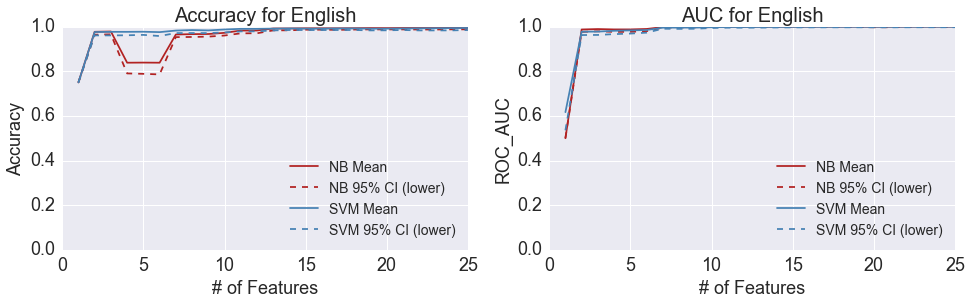

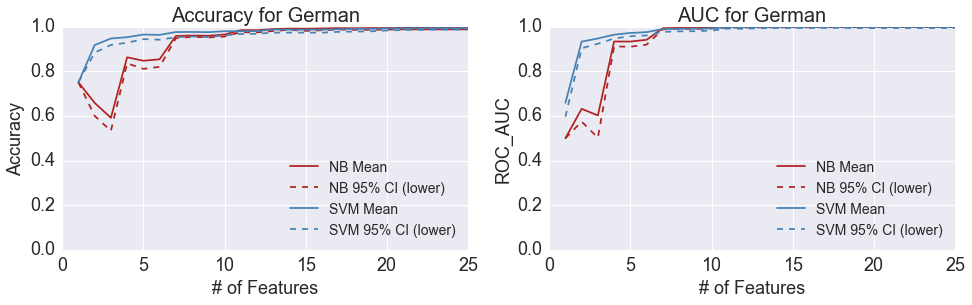

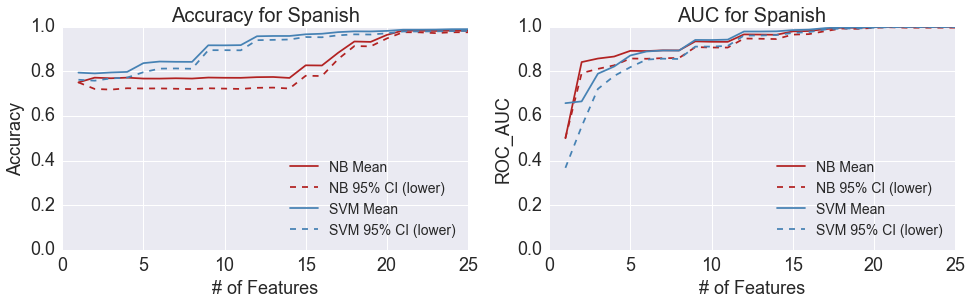

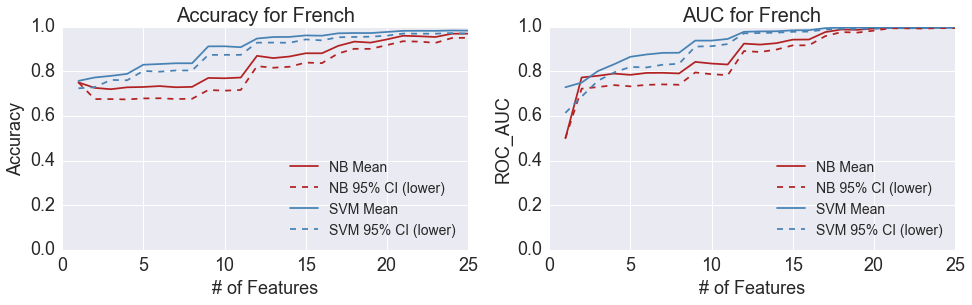

In [163]:
random.seed(123454321)
np.random.seed(123454321)

def experiment_1(corpi, language, num_features, feature_sample):
    
    # Fit to the feature space
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'acc_mean' : nb_results['test_accuracy'].mean(),
            'acc_95CI': nb_results['test_accuracy'].std() * 2,
            'acc_lower': nb_results['test_accuracy'].mean() - (nb_results['test_accuracy'].std() * 2),
            'auc_mean' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2,
            'auc_lower': nb_results['test_roc_auc'].mean() - (nb_results['test_roc_auc'].std() * 2)
        },
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }


# Get the feature sampling corpus once (10% of the whole corpora)
fs_corpus = skds.load_files(corpi['all'], encoding='UTF-8', shuffle=True)
feature_sample = train_test_split(fs_corpus.data, fs_corpus.target, train_size=.10)[0]

# Run experiment for each language
print "Experiment 1: English, German, Spanish and French - Features drawn from all corpora, uni&bi-grams"
for language in ['en','de','es','fr']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_1(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "NB Acc Mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['acc_mean'],
                                                                               exp_res['NB']['acc_lower'],
                                                                               exp_res['NB']['acc_95CI'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "NB AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['auc_mean'],
                                                                       exp_res['NB']['auc_lower'],
                                                                       exp_res['NB']['auc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    acc_mean = [result['NB']['acc_mean'] for result in results]
    acc_lower = [result['NB']['acc_lower'] for result in results]
    h1, = axes.plot(nf, acc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    auc_mean = [result['NB']['auc_mean'] for result in results]
    auc_lower = [result['NB']['auc_lower'] for result in results]
    h1, = axes.plot(nf, auc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)



------
**Experiment 2: Feature selection by language**
Considering the results using features extracted from the general codebase, we've just built a feature space with the hope that the individual categories (languages) differentiate within those top-N categories.  As we saw, it took **X**  features before any real discrimintaory power showed up. 

Now we'll investigate the selection of features by language, rather than training each language classifier on the same feature set. 

Parameters for this test are:
- Sample size of 10% across the _language_ corpus for constructing word features
- Word features identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,25].  Top words are selected based on their count within the language corpus sample
- Classifiers used were NaiveBayes & SVM:
    - Naive Bayes w/ default configuration:  alpha=1 (Laplace smoothing),  fit_prior=True
    - SVM w/ RBF & C=1, default RBF gamma?
- 10-fold Cross Validation run, reporting the mean test metrics for Accuracy, F1 Score & AUC

Experiment 2: English, German, Spanish and French - Top-N Uni & Bigrams from language, Count representation
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'the']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
SVM Acc mean:0.964 	Lower 95% CI:0.948 	+/- 95% CI:0.0150332963784
NB AUC mean:0.500 	Lower 95% CI:0.500 	+/- 95% CI:0.000
SVM AUC mean:0.957 	Lower 95% CI:0.938 	+/- 95% CI:0.0150332963784
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'of', u'the']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
SVM Acc mean:0.964 	Lower 95% CI:0.948 	+/- 95% CI:0.0159765453087
NB AUC mean:0.499 	Lower 95% CI:0.404 	+/- 95% CI:0.095
SVM AUC mean:0.967 	Lower 95% CI:0.940 	+/- 95% CI:0.0159765453087
----------------------------------
Results for (lang: en, features: 3)
Features selected

KeyError: 'accuracy'

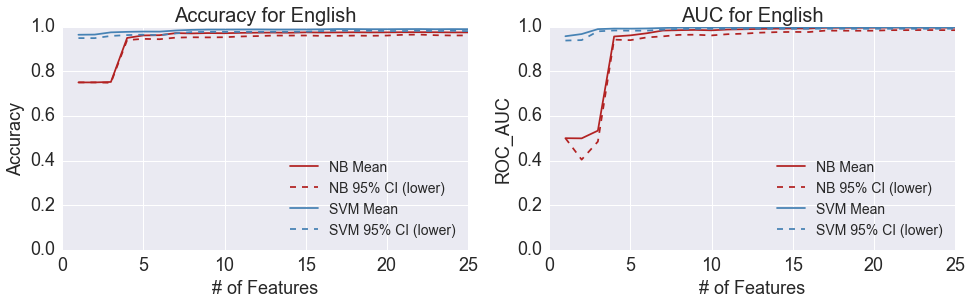

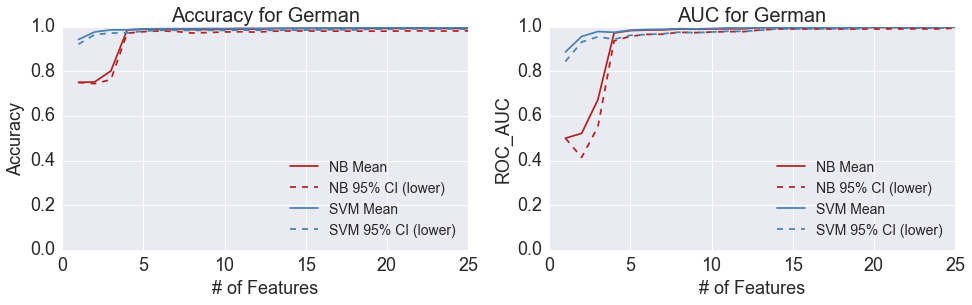

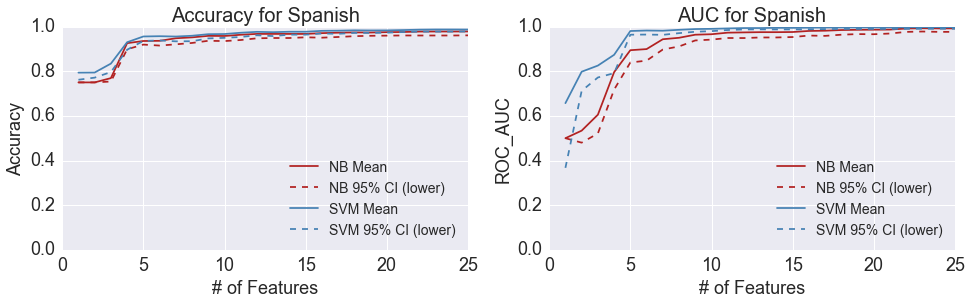

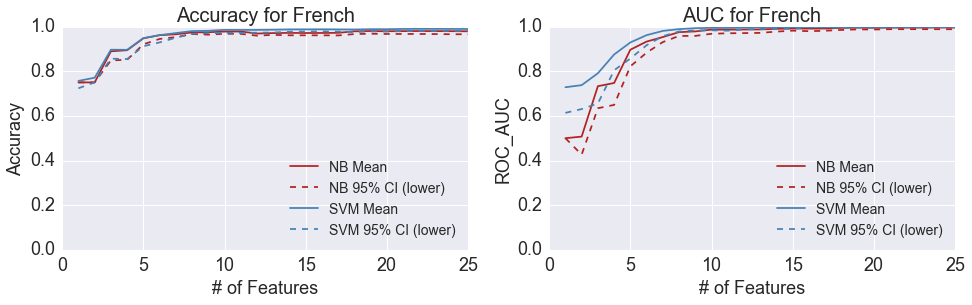

In [164]:
def experiment_2(corpi, language, num_features, feature_samples):
    # Fit the vectorizer based on the number of features
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_samples)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'acc_mean' : nb_results['test_accuracy'].mean(),
            'acc_95CI': nb_results['test_accuracy'].std() * 2,
            'acc_lower': nb_results['test_accuracy'].mean() - (nb_results['test_accuracy'].std() * 2),
            'auc_mean' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2,
            'auc_lower': nb_results['test_roc_auc'].mean() - (nb_results['test_roc_auc'].std() * 2)
        },
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }

# Run experiment for each language
print "Experiment 2: English, German, Spanish and French - Top-N Uni & Bigrams from language, Count representation"
for language in ['en','de','es','fr']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space as only the language of interest
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_2(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "NB Acc Mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['acc_mean'],
                                                                               exp_res['NB']['acc_lower'],
                                                                               exp_res['NB']['acc_95CI'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "NB AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['auc_mean'],
                                                                       exp_res['NB']['auc_lower'],
                                                                       exp_res['NB']['auc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    acc_mean = [result['NB']['acc_mean'] for result in results]
    acc_lower = [result['NB']['acc_lower'] for result in results]
    h1, = axes.plot(nf, acc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    auc_mean = [result['NB']['auc_mean'] for result in results]
    auc_lower = [result['NB']['auc_lower'] for result in results]
    h1, = axes.plot(nf, auc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)


**Experiment 3: Feature selection by language, Binary features (word is present or not)**

Focusing on language specific sampling for classification features appears to have improved things (why?), perhaps by selecting features relevant to that language's lexicon.

Within the corpus itself, we can consider looking at the feature frequency. For each document, how often does an individual term appear within the document?  

Parameters for this test are:
- Sample size of 10% from the language corpus for identifying word features
- Word features identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,25].  Top words are selected based on the frequency of their appearance in the corpus (# of unique documents they are in). The word feature presence in a document is modeled as a binary indicator variable. 
- Classifiers used were Naive Bayes & SVM
    - Naive Bayes w/ default configuration:  alpha=1 (Laplace smoothing),  fit_prior=True
    - SVM w/ RBF & C=1, default RBF gamma
- 10-fold Cross Validation run, reporting the mean test statistics for Accuracy, F1 & AUC

----

Experiment 3: English, German, Spanish and French - Top-N Uni & Bigrams from language, binary representation
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'the']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
SVM Acc mean:0.964 	Lower 95% CI:0.948 	+/- 95% CI:0.0150332963784
NB AUC mean:0.500 	Lower 95% CI:0.500 	+/- 95% CI:0.000
SVM AUC mean:0.959 	Lower 95% CI:0.940 	+/- 95% CI:0.0150332963784
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'and', u'the']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
SVM Acc mean:0.967 	Lower 95% CI:0.953 	+/- 95% CI:0.0139283882772
NB AUC mean:0.783 	Lower 95% CI:0.728 	+/- 95% CI:0.056
SVM AUC mean:0.985 	Lower 95% CI:0.977 	+/- 95% CI:0.0139283882772
----------------------------------
Results for (lang: en, features: 3)
Features select

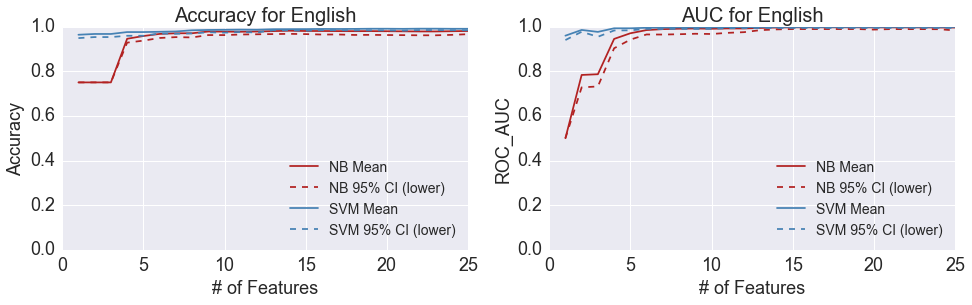

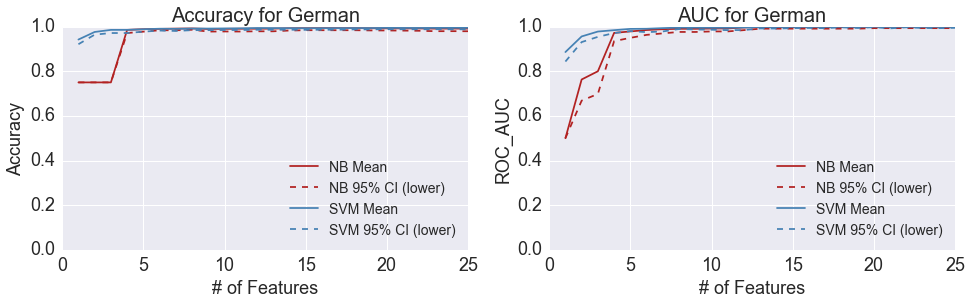

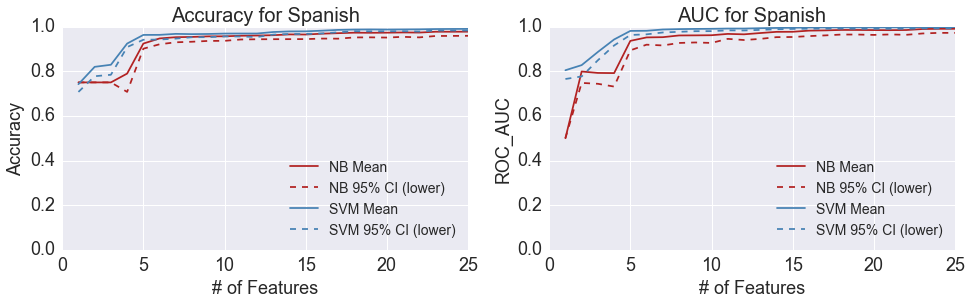

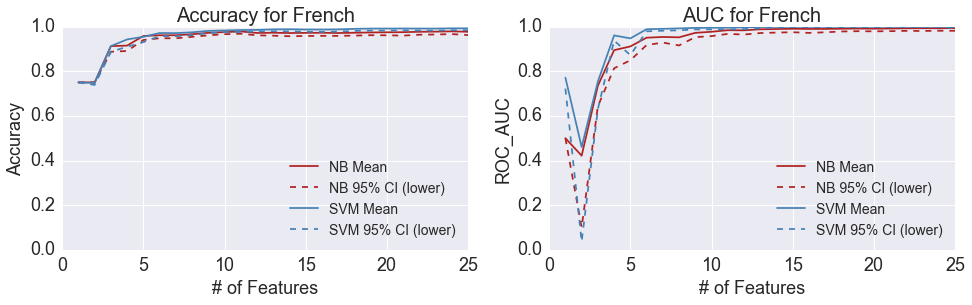

In [165]:
def experiment_3(corpi, language, num_features, feature_sample):
    
    # Discover features by count
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2), 
                                   max_features=num_features, token_pattern=single_char_token_pattern(), binary=True)
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','f1','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'acc_mean' : nb_results['test_accuracy'].mean(),
            'acc_95CI': nb_results['test_accuracy'].std() * 2,
            'acc_lower': nb_results['test_accuracy'].mean() - (nb_results['test_accuracy'].std() * 2),
            'auc_mean' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2,
            'auc_lower': nb_results['test_roc_auc'].mean() - (nb_results['test_roc_auc'].std() * 2)
        },
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }


# Run experiment for each language
print "Experiment 3: English, German, Spanish and French - Top-N Uni & Bigrams from language, binary representation"
for language in ['en','de','es','fr']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space as only the language of interest
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_3(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "NB Acc Mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['acc_mean'],
                                                                               exp_res['NB']['acc_lower'],
                                                                               exp_res['NB']['acc_95CI'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "NB AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['auc_mean'],
                                                                       exp_res['NB']['auc_lower'],
                                                                       exp_res['NB']['auc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    acc_mean = [result['NB']['acc_mean'] for result in results]
    acc_lower = [result['NB']['acc_lower'] for result in results]
    h1, = axes.plot(nf, acc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    auc_mean = [result['NB']['auc_mean'] for result in results]
    auc_lower = [result['NB']['auc_lower'] for result in results]
    h1, = axes.plot(nf, auc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)


---

**Experiment 4: Feature selection by language, Top-N represented as term frequency in document**

Focusing on language specific sampling for classification features appears to have improved things (why?), perhaps by selecting features relevant to that language's lexicon.

Within the corpus itself, we can consider looking at the feature frequency. For each document, how often does an individual term appear within the document?  

Parameters for this test are:
- Sample size of 10% from the language corpus for identifying word features
- Word features identified as follows:
    - alpha only (no numeric characters)
    - 1 character minimum length
- Top N word features are selected where N in [1,30].  Top words are selected based on their frequency within the language corpus sample.  Use_idf=False
- Classifiers used were Naive Bayes & SVM
    - Naive Bayes w/ default configuration:  alpha=1 (Laplace smoothing),  fit_prior=True
    - SVM w/ RBF & C=1, default RBF gamma
- 10-fold Cross Validation run, reporting the mean test statistics for Accuracy, F1 & AUC

Experiment 4:  Top N unigrams and bigrams, Term Frequency representation
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'the']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
NB AUC mean:0.500 	Lower 95% CI:0.500 	+/- 95% CI:0.000
SVM Acc mean:0.964 	Lower 95% CI:0.948 	+/- 95% CI:0.0150332963784
SVM AUC mean:0.959 	Lower 95% CI:0.940 	+/- 95% CI:0.0150332963784
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'in', u'the']
NB Acc Mean:0.875 	Lower 95% CI:0.852 	+/- 95% CI:0.023
NB AUC mean:0.887 	Lower 95% CI:0.854 	+/- 95% CI:0.033
SVM Acc mean:0.963 	Lower 95% CI:0.947 	+/- 95% CI:0.0157241851935
SVM AUC mean:0.972 	Lower 95% CI:0.947 	+/- 95% CI:0.0157241851935
----------------------------------
Results for (lang: en, features: 3)
Features selected: [u'in', u'of', u'the']
NB Acc Mea

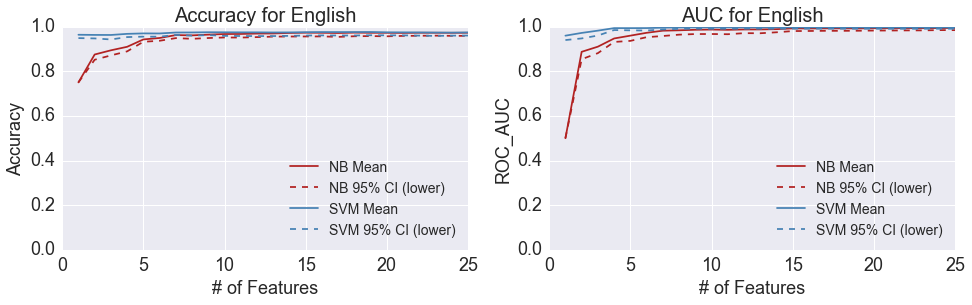

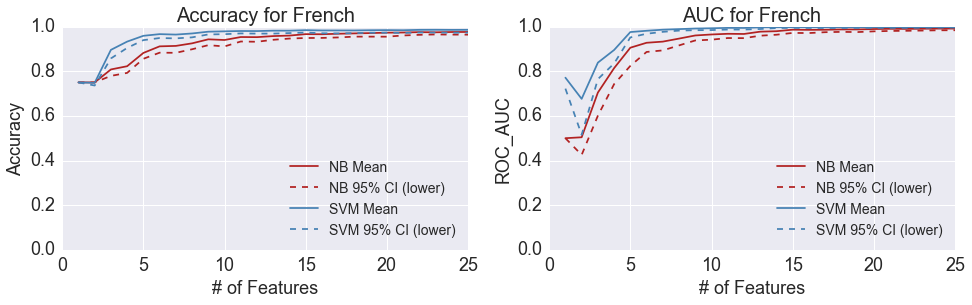

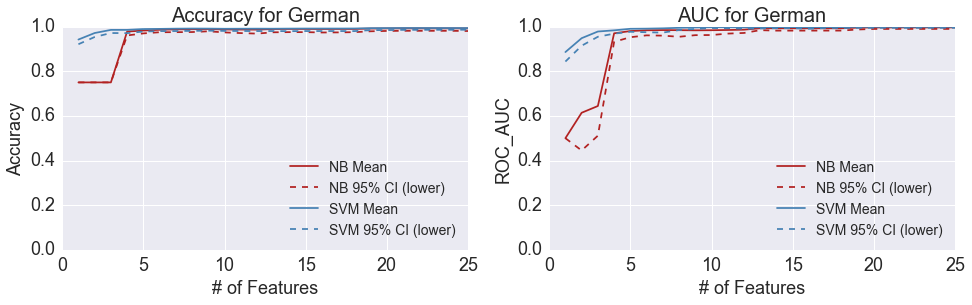

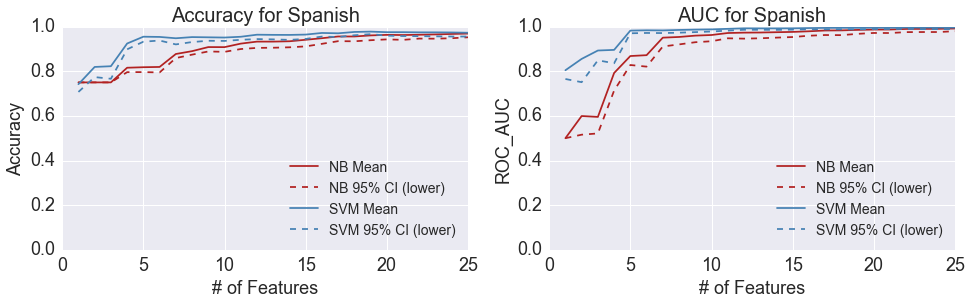

In [167]:
def experiment_4(corpi, language, num_features, feature_sample):
    
    # Feature extraction
    vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', use_idf=False, ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'acc_mean' : nb_results['test_accuracy'].mean(),
            'acc_95CI': nb_results['test_accuracy'].std() * 2,
            'acc_lower': nb_results['test_accuracy'].mean() - (nb_results['test_accuracy'].std() * 2),
            'auc_mean' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2,
            'auc_lower': nb_results['test_roc_auc'].mean() - (nb_results['test_roc_auc'].std() * 2)
        },
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }



# Run experiment for each language
print "Experiment 4:  Top N unigrams and bigrams, Term Frequency representation"
for language in ['en','fr','de','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_4(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "NB Acc Mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['acc_mean'],
                                                                               exp_res['NB']['acc_lower'],
                                                                               exp_res['NB']['acc_95CI'])
        print "NB AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['auc_mean'],
                                                                       exp_res['NB']['auc_lower'],
                                                                       exp_res['NB']['auc_95CI'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    acc_mean = [result['NB']['acc_mean'] for result in results]
    acc_lower = [result['NB']['acc_lower'] for result in results]
    h1, = axes.plot(nf, acc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    auc_mean = [result['NB']['auc_mean'] for result in results]
    auc_lower = [result['NB']['auc_lower'] for result in results]
    h1, = axes.plot(nf, auc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

**Experiment 5** Top-N Bigrams only with counts

Experiment 5: Bi-grams Only
----------------------------------
----------------------------------
Starting experiments for language en
----------------------------------
Results for (lang: en, features: 1)
Features selected: [u'of the']
NB Acc Mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.000
SVM Acc mean:0.846 	Lower 95% CI:0.819 	+/- 95% CI:0.0273175767593
NB AUC mean:0.500 	Lower 95% CI:0.500 	+/- 95% CI:0.000
SVM AUC mean:0.698 	Lower 95% CI:0.644 	+/- 95% CI:0.0273175767593
----------------------------------
Results for (lang: en, features: 2)
Features selected: [u'in the', u'of the']
NB Acc Mean:0.804 	Lower 95% CI:0.769 	+/- 95% CI:0.035
SVM Acc mean:0.896 	Lower 95% CI:0.872 	+/- 95% CI:0.0238956062907
NB AUC mean:0.555 	Lower 95% CI:0.482 	+/- 95% CI:0.073
SVM AUC mean:0.799 	Lower 95% CI:0.744 	+/- 95% CI:0.0238956062907
----------------------------------
Results for (lang: en, features: 3)
Features selected: [u'in the', u'of the', u'to the']
NB Acc Mean:0.795 	Lower 95% CI:0.

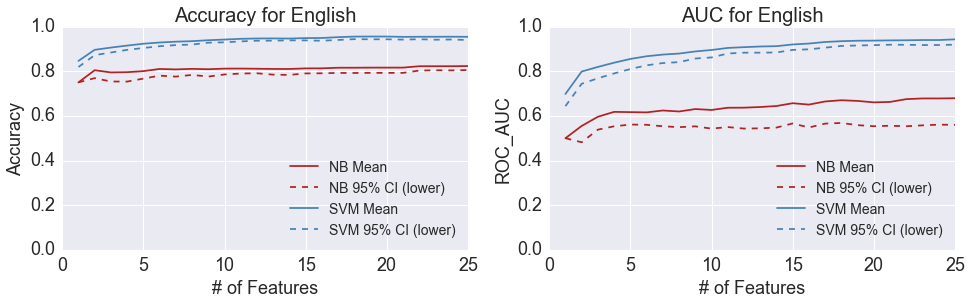

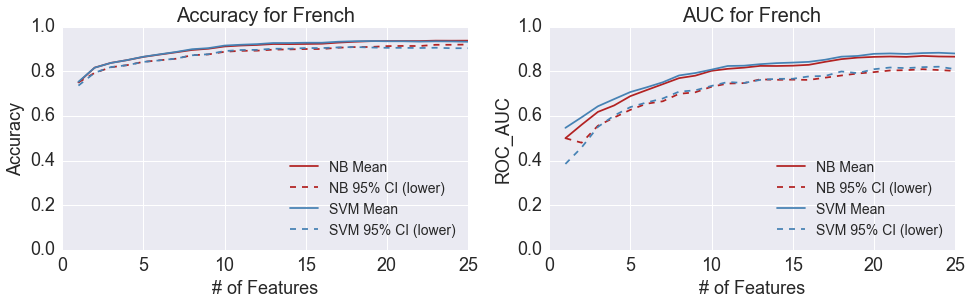

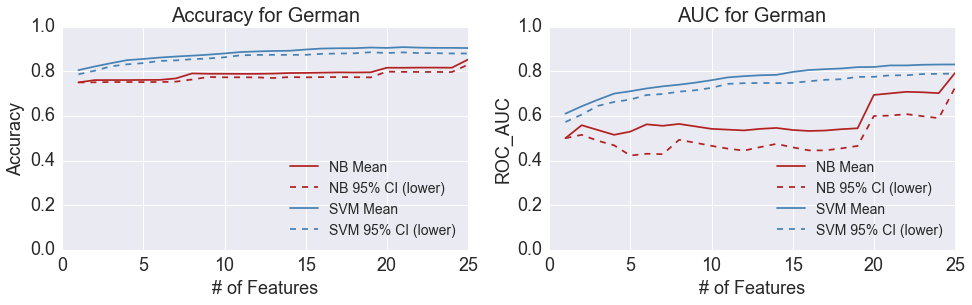

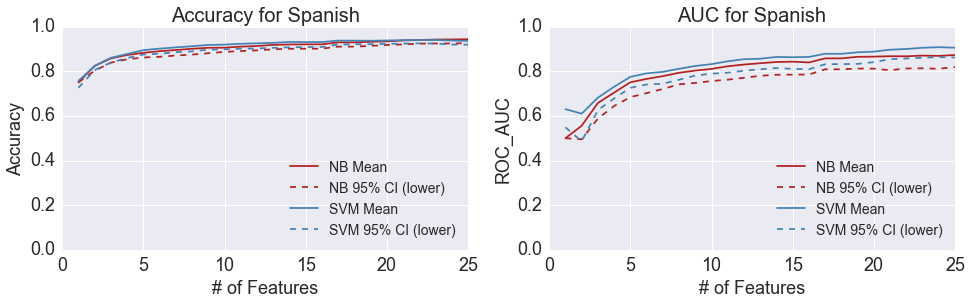

In [169]:
def experiment_5(corpi, language, num_features, feature_sample):
    # Fit vectorizer
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(2,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate a Naive Bayes Classifier
    classifier = MultinomialNB(fit_prior=True)
    scoring = ['accuracy','roc_auc']
    nb_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'NB' : {
            'acc_mean' : nb_results['test_accuracy'].mean(),
            'acc_95CI': nb_results['test_accuracy'].std() * 2,
            'acc_lower': nb_results['test_accuracy'].mean() - (nb_results['test_accuracy'].std() * 2),
            'auc_mean' : nb_results['test_roc_auc'].mean(),
            'auc_95CI': nb_results['test_roc_auc'].std() * 2,
            'auc_lower': nb_results['test_roc_auc'].mean() - (nb_results['test_roc_auc'].std() * 2)
        },
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }


# Run experiment for each language
print "Experiment 5: Bi-grams Only"
for language in ['en','fr','de','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_5(corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "NB Acc Mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['acc_mean'],
                                                                               exp_res['NB']['acc_lower'],
                                                                               exp_res['NB']['acc_95CI'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "NB AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2:.3F}".format(exp_res['NB']['auc_mean'],
                                                                       exp_res['NB']['auc_lower'],
                                                                       exp_res['NB']['auc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    acc_mean = [result['NB']['acc_mean'] for result in results]
    acc_lower = [result['NB']['acc_lower'] for result in results]
    h1, = axes.plot(nf, acc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, acc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2,h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # NB plot
    auc_mean = [result['NB']['auc_mean'] for result in results]
    auc_lower = [result['NB']['auc_lower'] for result in results]
    h1, = axes.plot(nf, auc_mean, color='firebrick', label='NB Mean')
    h2, = axes.plot(nf, auc_lower, color='firebrick', linestyle='dashed', label='NB 95% CI (lower)')
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2, h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

-----

**Lexical similarity**

**Experiment 6** How do we do when classifying languages with high lexical similarity?  Spanish, Italian, Portuguese and French. 

Experiment 6: Lexically Similar languages - word features from all corpora
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
SVM Acc mean:0.749 	Lower 95% CI:0.746 	+/- 95% CI:0.00331662479036
SVM AUC mean:0.518 	Lower 95% CI:0.345 	+/- 95% CI:0.00331662479036
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
SVM Acc mean:0.766 	Lower 95% CI:0.750 	+/- 95% CI:0.016
SVM AUC mean:0.662 	Lower 95% CI:0.590 	+/- 95% CI:0.016
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'a', u'de', u'la']
SVM Acc mean:0.786 	Lower 95% CI:0.759 	+/- 95% CI:0.0270370116692
SVM AUC mean:0.732 	Lower 95% CI:0.689 	+/- 95% CI:0.0270370116692
----------------------------------
Results for (lang: fr, features: 4)
Features selected: [u'a', u'de', u'en', u'la']
SV

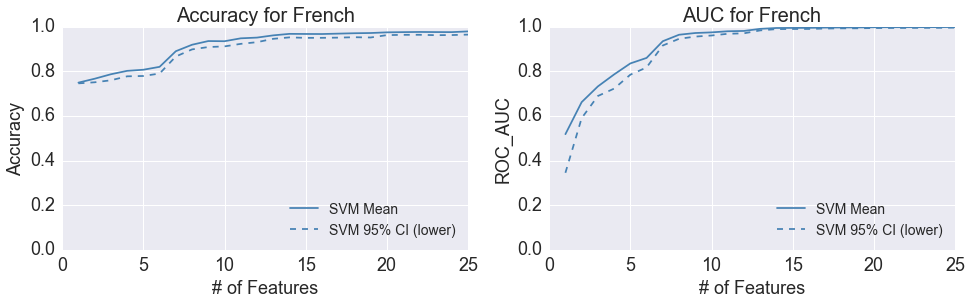

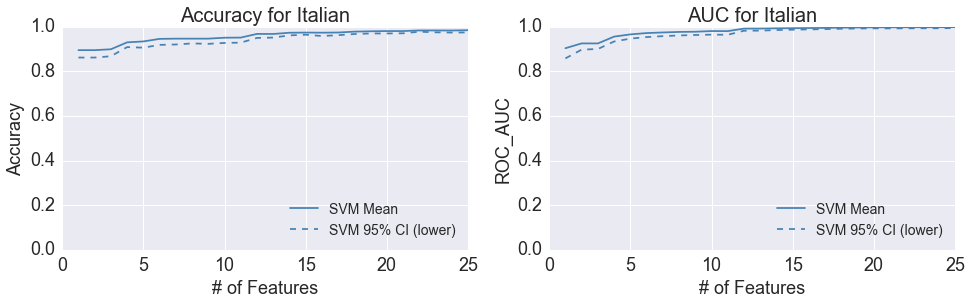

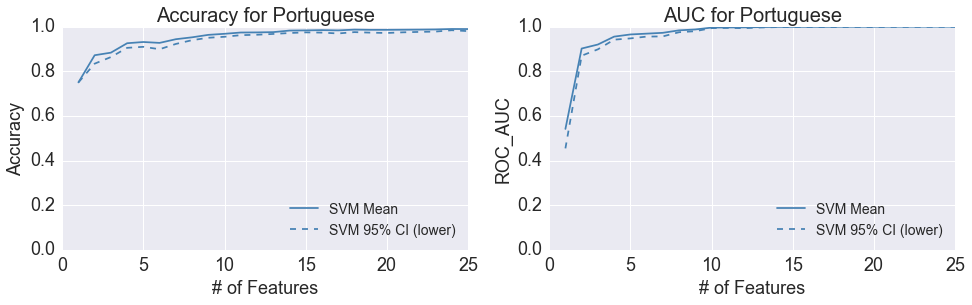

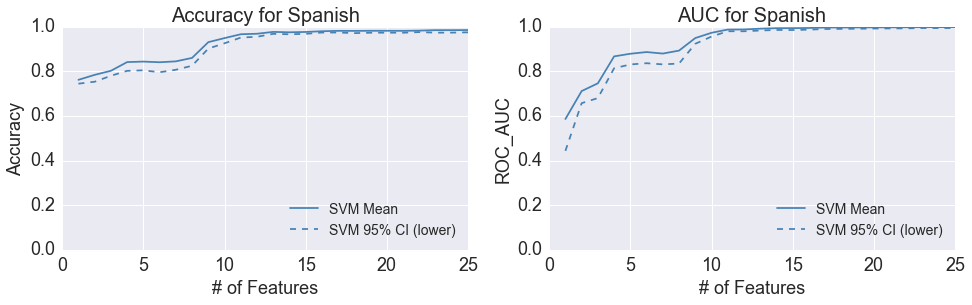

In [171]:
random.seed(123454321)
np.random.seed(123454321)

def experiment_6(corpi, language, num_features, feature_sample):
    
    # Fit vectorizer
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern())
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }



# Run experiment for each language
print "Experiment 6: Lexically Similar languages - word features from all corpora"
for language in ['fr','it','pt','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(lex_corpi['all'], encoding='UTF-8', shuffle=True)
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_7(lex_corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h1, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h2, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h1, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h2, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h1, h2], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

**Experiment 7**:  Language specific words, uni-grams & bi-grams, SVM only, binary representation

Experiment 7: Lexically Similar languages - word features from each language corpus
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
SVM Acc mean:0.749 	Lower 95% CI:0.746 	+/- 95% CI:0.00331662479036
SVM AUC mean:0.518 	Lower 95% CI:0.345 	+/- 95% CI:0.00331662479036
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'la']
SVM Acc mean:0.766 	Lower 95% CI:0.750 	+/- 95% CI:0.016
SVM AUC mean:0.662 	Lower 95% CI:0.590 	+/- 95% CI:0.016
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'de', u'la', u'le']
SVM Acc mean:0.874 	Lower 95% CI:0.845 	+/- 95% CI:0.0286574597618
SVM AUC mean:0.798 	Lower 95% CI:0.733 	+/- 95% CI:0.0286574597618
----------------------------------
Results for (lang: fr, features: 4)
Features selected: [u'de', u'et', u'la'

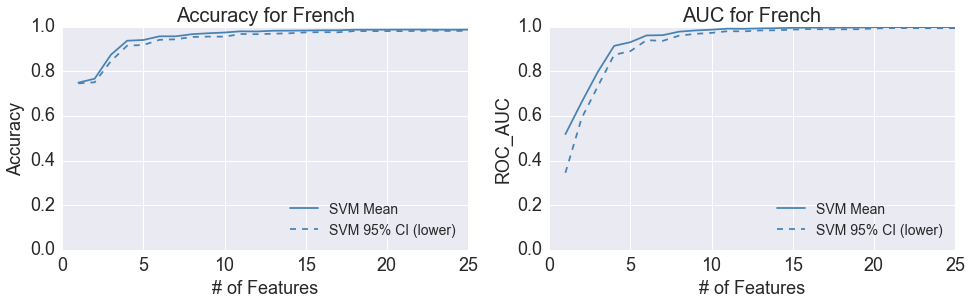

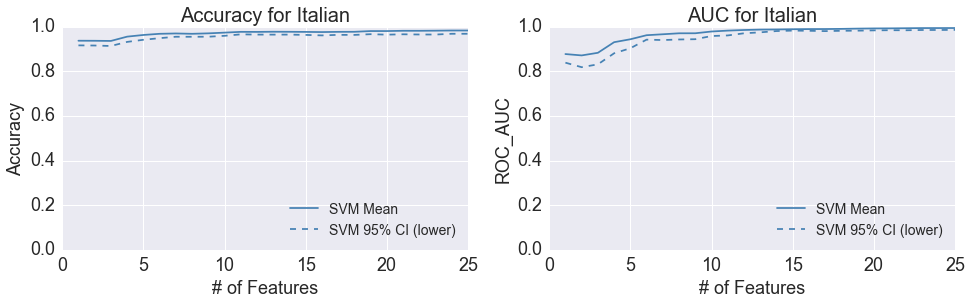

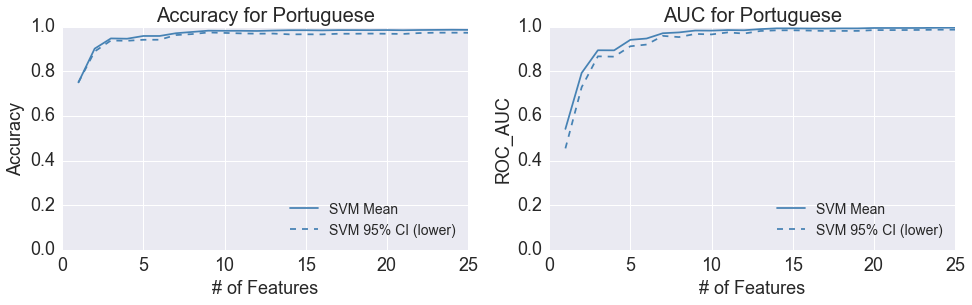

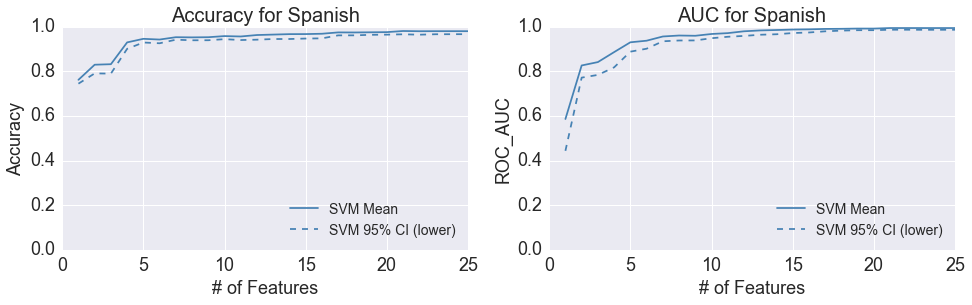

In [183]:
def experiment_7(corpi, language, num_features, feature_sample):
    
    # Fit vectorizer
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=single_char_token_pattern(), binary=True)
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=['accuracy','roc_auc'])
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }



# Run experiment for each language
print "Experiment 7: Lexically Similar languages - word features from each language corpus"
for language in ['fr','it','pt','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(lex_corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_8(lex_corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

**Reference:** Language specific bi-grams

In [157]:
it_features = [u'con la', u'dans la', u'dans le', u'dans les', u'de la', u'de um', u'de uma', u'dell alfabeto', u'di un', u'em de', u'est un', u'est une', u'et de', u'et la', u'et le', u'il est', u'il suo', u'la lettera', u'la lettre', u'la sua', u'la ville', u'of the', u'par la', u'per il', u'per la']
it_features = set(it_features)

pt_features = [u'con la', u'dans la', u'dans le', u'dans les', u'de la', u'de um', u'dell alfabeto', u'di un', u'em de', u'est un', u'est une', u'et de', u'et la', u'et le', u'il est', u'la lettera', u'la lettre', u'la sua', u'la ville', u'of the', u'par la', u'par le', u'per il', u'per la', u'utilis\xe9e dans']
pt_features = set(pt_features)

fr_features = [u'con la', u'dans la', u'dans le', u'dans les', u'de la', u'de son', u'de um', u'di un', u'em de', u'est un', u'est une', u'et de', u'et la', u'il est', u'il suo', u'la lettera', u'la lettre', u'la prima', u'la sua', u'la ville', u'of the', u'par la', u'per il', u'per la', u'qu il']
fr_features = set(fr_features)

print set.intersection(it_features, pt_features, fr_features)


print "Difference between IT and PT: {0}".format(set.difference(it_features, pt_features))
print "Difference between IT and FR: {0}".format(set.difference(it_features, fr_features))
print 'Difference between PR and FR: {0}'.format(set.difference(pt_features, fr_features))


set([u'dans les', u'em de', u'di un', u'of the', u'et de', u'par la', u'de um', u'dans la', u'con la', u'la lettre', u'la ville', u'dans le', u'est une', u'de la', u'il est', u'per la', u'est un', u'et la', u'la lettera', u'la sua', u'per il'])
Difference between IT and PT: set([u'il suo', u'de uma'])
Difference between IT and FR: set([u'de uma', u'et le', u'dell alfabeto'])
Difference between PR and FR: set([u'utilis\xe9e dans', u'par le', u'et le', u'dell alfabeto'])


**Experiment 8**:  Word length increased to 2 characters minimum

Experiment 8: Lexically Similar languages - character ngrams
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de']
SVM Acc mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.0
SVM AUC mean:0.629 	Lower 95% CI:0.588 	+/- 95% CI:0.0
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de', u'le']
SVM Acc mean:0.872 	Lower 95% CI:0.843 	+/- 95% CI:0.0296647939484
SVM AUC mean:0.828 	Lower 95% CI:0.777 	+/- 95% CI:0.0296647939484
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'de', u'la', u'le']
SVM Acc mean:0.872 	Lower 95% CI:0.843 	+/- 95% CI:0.0296647939484
SVM AUC mean:0.712 	Lower 95% CI:0.644 	+/- 95% CI:0.0296647939484
----------------------------------
Results for (lang: fr, features: 4)
Features selected: [u'de', u'et', u'la', u'le']
SVM Acc mean:0.929 	

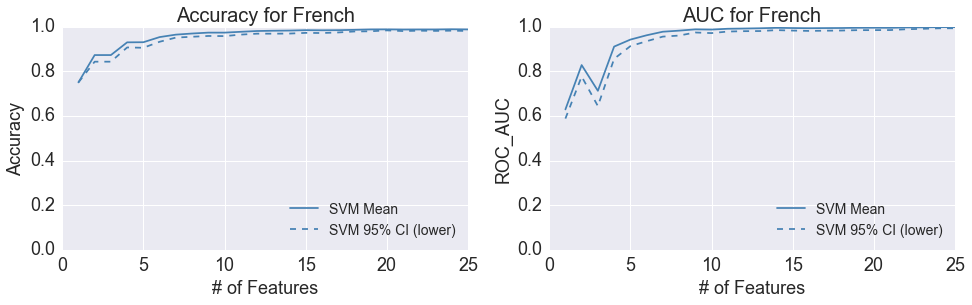

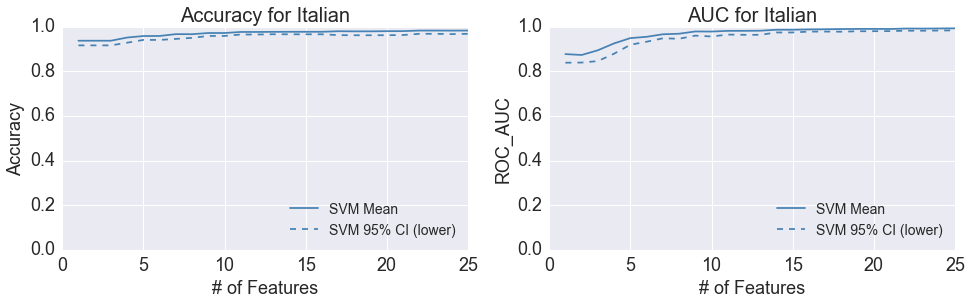

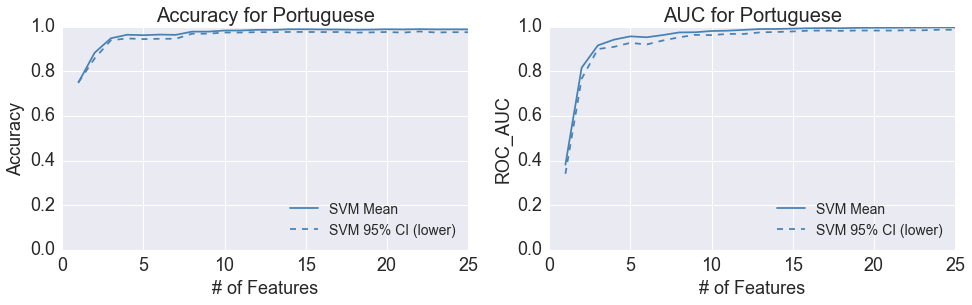

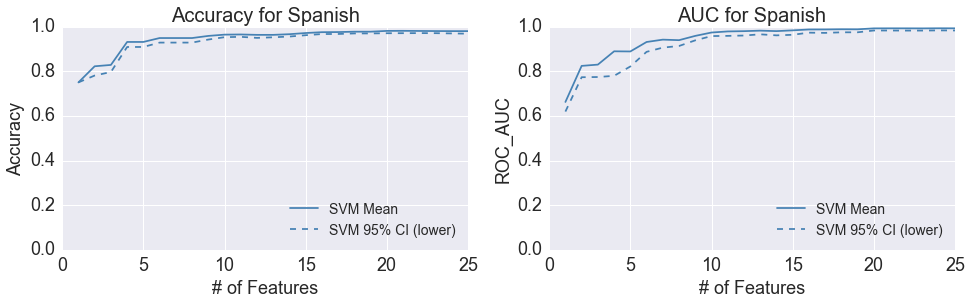

In [184]:
def experiment_8(corpi, language, num_features, feature_sample):
    
    # Fit vectorizer
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(1,2),
                                   max_features=num_features, token_pattern=token_pattern(), binary=True)
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=['accuracy','roc_auc'])
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }



# Run experiment for each language
print "Experiment 8: Lexically Similar languages - character ngrams"
for language in ['fr','it','pt','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(lex_corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_8(lex_corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

**Experiment 9** Trigrams, binary

Experiment 9: Lexically Similar languages - character ngrams
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'de la']
SVM Acc mean:0.750 	Lower 95% CI:0.750 	+/- 95% CI:0.0
SVM AUC mean:0.620 	Lower 95% CI:0.573 	+/- 95% CI:0.0
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'de la', u'est un']
SVM Acc mean:0.780 	Lower 95% CI:0.763 	+/- 95% CI:0.0163477827243
SVM AUC mean:0.640 	Lower 95% CI:0.504 	+/- 95% CI:0.0163477827243
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'de la', u'est un', u'est une']
SVM Acc mean:0.803 	Lower 95% CI:0.782 	+/- 95% CI:0.0210713075057
SVM AUC mean:0.678 	Lower 95% CI:0.565 	+/- 95% CI:0.0210713075057
----------------------------------
Results for (lang: fr, features: 4)
Features selected: [u'dans le', u'de la', u'es

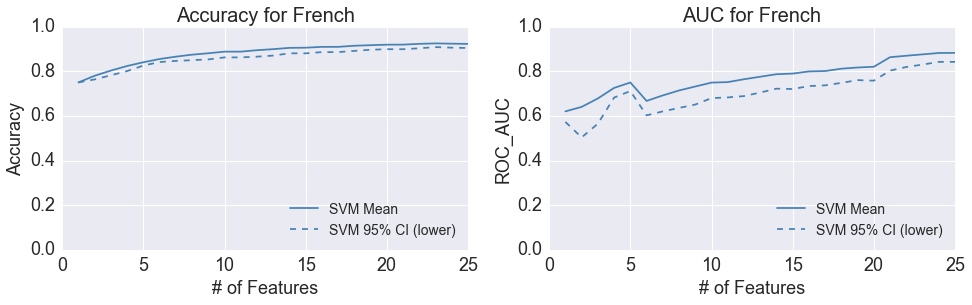

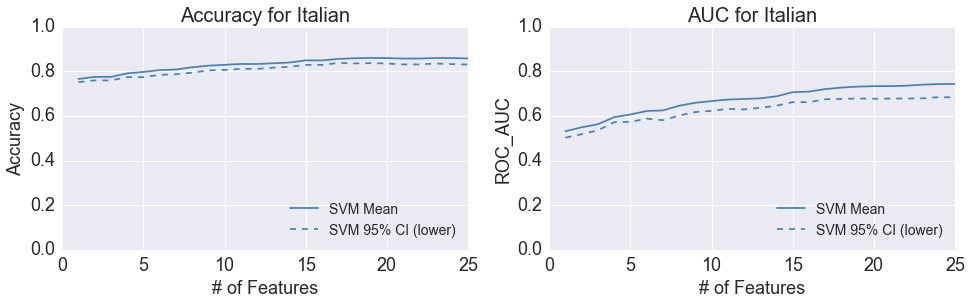

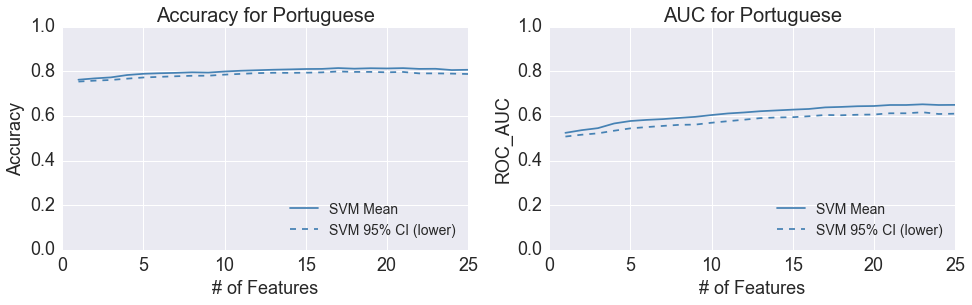

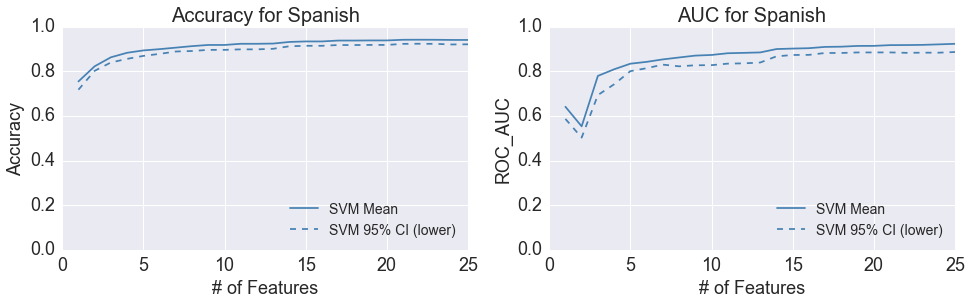

In [185]:
def experiment_9(corpi, language, num_features, feature_sample):
    
    # Fit vectorizer
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', ngram_range=(2,2),
                                   max_features=num_features, binary=True)
    vectorizer.fit(feature_sample)
    
    # Load the language corpus & fit a Naive Bayes classifier
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    X = vectorizer.transform(corpus.data)
    y = corpus.target
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=['accuracy','roc_auc'])
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    return {
        'num_features' : num_features,
        'features': vectorizer.get_feature_names(),
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }



# Run experiment for each language
print "Experiment 9: Lexically Similar languages - character ngrams"
for language in ['fr','it','pt','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(lex_corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for num_features in range(1, 25+1):
        exp_res = experiment_9(lex_corpi, language, num_features, feature_sample)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)

**Experiment 10**:  Chi^2 test

Experiment 10: Chi^2 for separation
----------------------------------
----------------------------------
Starting experiments for language fr
----------------------------------
Results for (lang: fr, features: 1)
Features selected: [u'et']
SVM Acc mean:0.910 	Lower 95% CI:0.886 	+/- 95% CI:0.0239791576166
SVM AUC mean:0.825 	Lower 95% CI:0.777 	+/- 95% CI:0.0239791576166
----------------------------------
Results for (lang: fr, features: 2)
Features selected: [u'est', u'et']
SVM Acc mean:0.953 	Lower 95% CI:0.932 	+/- 95% CI:0.0209523268398
SVM AUC mean:0.917 	Lower 95% CI:0.875 	+/- 95% CI:0.0209523268398
----------------------------------
Results for (lang: fr, features: 3)
Features selected: [u'du', u'est', u'et']
SVM Acc mean:0.967 	Lower 95% CI:0.950 	+/- 95% CI:0.0169115345253
SVM AUC mean:0.947 	Lower 95% CI:0.917 	+/- 95% CI:0.0169115345253
----------------------------------
Results for (lang: fr, features: 4)
Features selected: [u'du', u'est', u'et', u'les']
SVM Acc mean:0.97

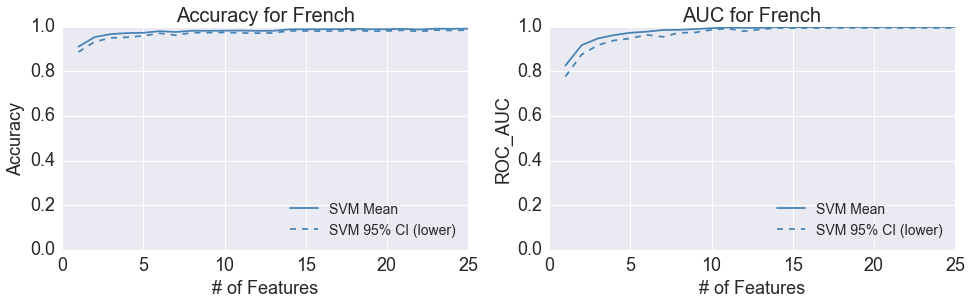

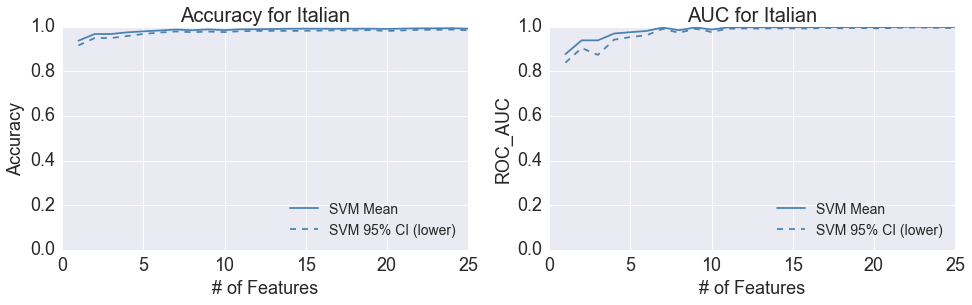

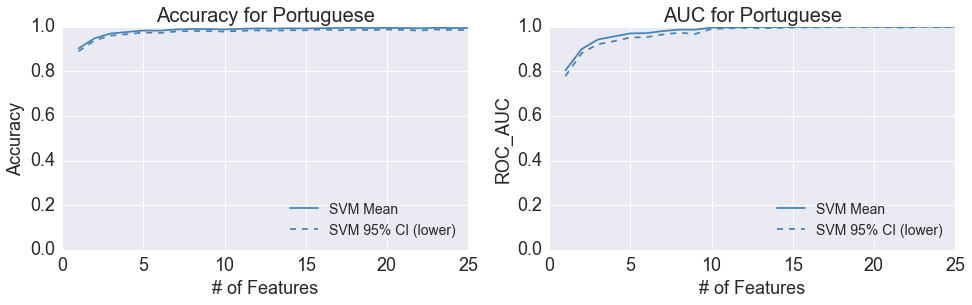

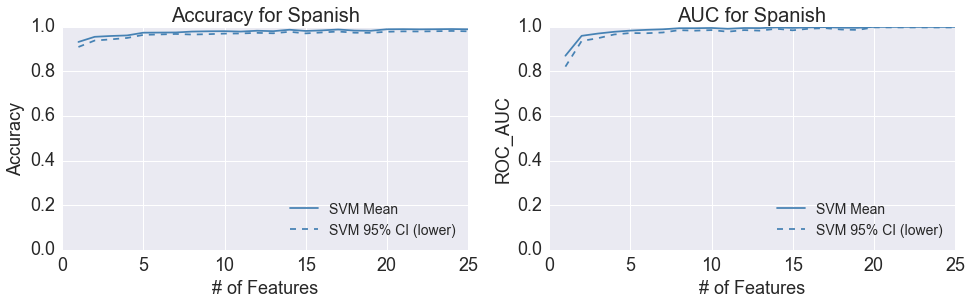

In [186]:
def experiment_10(corpi, language, k, feature_sampling_perc=.10):
    
    # get whole corpus 
    corpus = skds.load_files(corpi[language], encoding='UTF-8', shuffle=True)
    
    # Discover all word features & transform 
    X, X_t, y, y_t = train_test_split(corpus.data, corpus.target, train_size=feature_sampling_perc)
    vectorizer = CountVectorizer(analyzer='word', lowercase=True, encoding='UTF-8', 
                                 token_pattern=single_char_token_pattern(), binary=True)
    X = vectorizer.fit_transform(X)
    
    # Feature selection
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y)
    indices = selector.get_support(indices=True)
    
    # Transform
    X = selector.transform(vectorizer.transform(corpus.data))
    y = corpus.target
    
    # Fit and evaluate an SVM
    classifier = svm.SVC(kernel='rbf', C=1)
    svm_results = cross_validate(classifier, X, y, cv=10, scoring=['accuracy','roc_auc'])
    
    # kernel=rbf (default)
    # decision function shape = ovo ( one-vs-rest) - original decision function in libsvm
    #  tol is the default 1e-3
    # default C = 1
    feature_names = []
    for index in indices:
        feature_names.append(vectorizer.get_feature_names()[index])
    return {
        'num_features' : len(feature_names),
        'features': feature_names,
        'SVM' : {
            'acc_mean': svm_results['test_accuracy'].mean(),
            'acc_95CI' : svm_results['test_accuracy'].std() * 2,
            'acc_lower': svm_results['test_accuracy'].mean() - (svm_results['test_accuracy'].std() * 2),
            'auc_mean': svm_results['test_roc_auc'].mean(),
            'auc_95CI': svm_results['test_roc_auc'].std() * 2,
            'auc_lower': svm_results['test_roc_auc'].mean() - (svm_results['test_roc_auc'].std() * 2)
        }
    }

# using Chi^2 for feature separation



# Run experiment for each language
print "Experiment 10: Chi^2 for separation"
for language in ['fr','it','pt','es']:
    
    # Run tests for a language
    print "----------------------------------"
    print "----------------------------------"
    print "Starting experiments for language {0}".format(language)
    
    # Extract feature space
    corpus = skds.load_files(lex_corpi[language], encoding='UTF-8', shuffle=True, categories=[language])
    feature_sample = train_test_split(corpus.data, corpus.target, train_size=.10)[0]
    
    feature_ranks = []
    results = []
    
    # run the experiment
    for k in range(1, 25+1):
        exp_res = experiment_10(lex_corpi, language, k)
        print "----------------------------------"
        print "Results for (lang: {0}, features: {1})".format(language, exp_res['num_features'])
        print "Features selected: {0}".format(exp_res['features'])
        print "SVM Acc mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['acc_mean'],
                                                                                exp_res['SVM']['acc_lower'],
                                                                                exp_res['SVM']['acc_95CI'])
        print "SVM AUC mean:{0:.3F} \tLower 95% CI:{1:.3F} \t+/- 95% CI:{2}".format(exp_res['SVM']['auc_mean'],
                                                                           exp_res['SVM']['auc_lower'],
                                                                           exp_res['SVM']['acc_95CI'])
        results.append(exp_res)
        
        if len(feature_ranks) == 0:
            feature_ranks.append(exp_res['features'][0])
        else:
            for feature in exp_res['features']:
                if feature not in feature_ranks:
                    feature_ranks.append(feature)

    # Plotting NB
    figure = plt.figure(figsize=(16,4))
    nf = [result['num_features'] for result in results]
    
    # Accuracy on NB, SVM
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Accuracy for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    acc_mean = [result['SVM']['acc_mean'] for result in results]
    acc_lower = [result['SVM']['acc_lower'] for result in results]
    h3, = axes.plot(nf, acc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, acc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("Accuracy")
    axes.set_ylim([0,1])
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)


    # AUC on NB, SVM
    axes = figure.add_subplot(1,2,2)
    axes.set_title("AUC for {0}".format(lang_map[language]))
    axes.title.set_fontsize(title_fontsize)
    # SVM plot
    auc_mean = [result['SVM']['auc_mean'] for result in results]
    auc_lower = [result['SVM']['auc_lower'] for result in results]
    h3, = axes.plot(nf, auc_mean, color='steelblue', label='SVM Mean')
    h4, = axes.plot(nf, auc_lower, color='steelblue', linestyle='dashed', label='SVM 95% CI (lower)')
    axes.legend(handles=[h3, h4], loc='lower right', prop= {'size': legend_fontsize})
    axes.set_ylim([0,1])
    axes.set_ylabel("ROC_AUC")
    axes.yaxis.get_label().set_fontsize(y_axis_fontsize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_axis_fontsize)
    axes.set_xlabel("# of Features")
    axes.xaxis.get_label().set_fontsize(x_axis_fontsize)
    for tick in axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_axis_fontsize)
    axes.set_ylim([0,1])

    print "Features in rank order were {0}".format(feature_ranks)
    print "Finished experiments for language {0}".format(language)



